In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from Utils import *
from Evaluation import *
from Classes import ABQuadrupel
import matplotlib.pyplot as plt
from pathlib import Path
import os
import pandas as pd

# Hefekulturen

## Define Files to Evaluate

Please edit the path to the reference plate (`path_to_reference_plate`) and experiment plate (`path_to_experiment_plate`) as well as the folder to save the results to (`save_results_folder`)

**Attention** Please make sure that the images are cropped, in such way that only the yeast colonies are visible.

In [16]:
path_to_reference_plate = r"./Data\36_MPA_Cu0_d3.JPG"
path_to_experiment_plate = r"./Data/36_MPA_ref_d3.JPG"
save_results_folder = r"./Results/"

In [17]:
# IMG_SIZE = 8
MIN_COLONY_SIZE = 250
P_VALUE_NULLHYPOTHESIS = 0.01

In [18]:
os.makedirs(save_results_folder, exist_ok=True)

## Open and Preprocess Images

### Open Images as Binary

c:\Users\Hannah\anaconda3\envs\hefekulturen\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Hannah\anaconda3\envs\hefekulturen\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


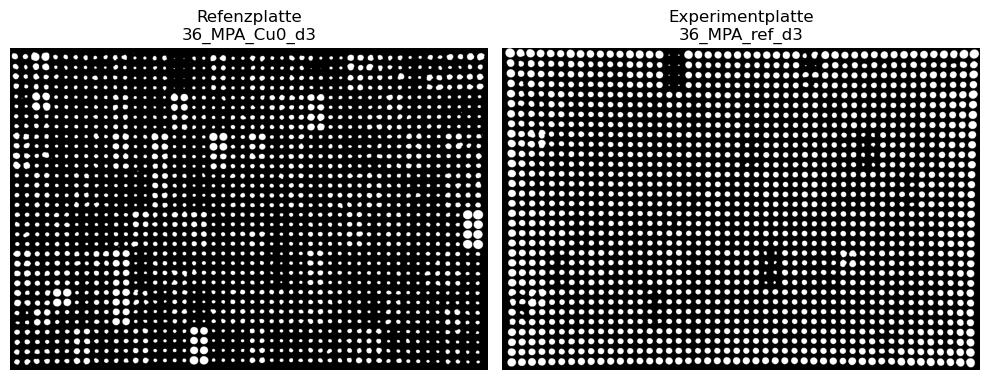

In [19]:
reference_plate = open_image(path_to_reference_plate)
experiment_plate = open_image(path_to_experiment_plate)

fig, axs = plt.subplots(1,2, figsize = (10,10*2))
axs[0].imshow(reference_plate, cmap="gray")
axs[1].imshow(experiment_plate, cmap="gray")
axs[0].set_title("Refenzplatte\n"+Path(path_to_reference_plate).stem)
axs[1].set_title("Experimentplatte\n"+Path(path_to_experiment_plate).stem)
axs[0].set_axis_off()
axs[1].set_axis_off()
plt.tight_layout()
plt.show()

### Compute Colony Sizes

Hint: if grid is not working properly, try to increase/decrease `erosion_iterations_ref` or `erosion_iterations_exp` by $\pm 1$

In [20]:
erosion_iterations_ref = 4
erosion_iterations_exp = 4


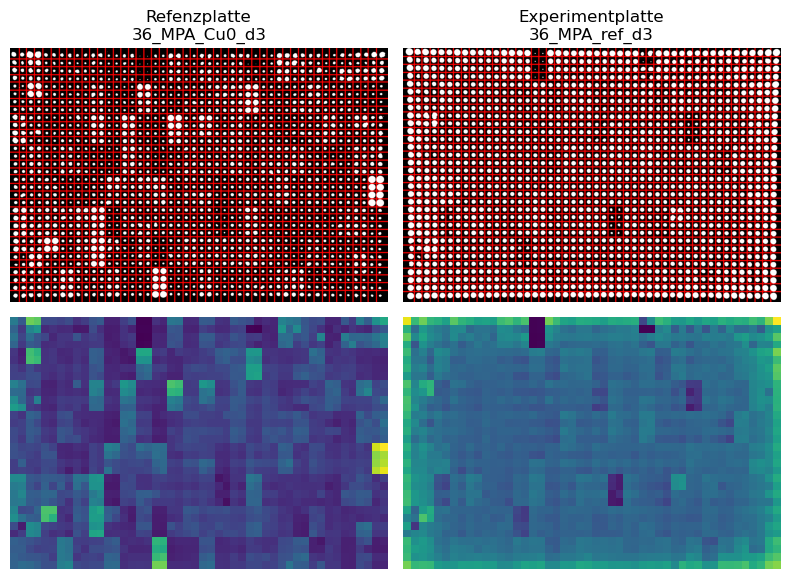

In [21]:
rgb_grid_reference, xmins_idx_reference, ymins_idx_reference = compute_grid(reference_plate, erosion_iterations = erosion_iterations_ref)
rgb_grid_experiment, xmins_idx_experiment, ymins_idx_experiment = compute_grid(experiment_plate, erosion_iterations = erosion_iterations_exp)

sizes_reference,_,_,_,_ = compute_sizes(reference_plate, xmins_idx_reference, ymins_idx_reference)
sizes_experiment, x_start, x_end, y_start, y_end = compute_sizes(experiment_plate, xmins_idx_experiment, ymins_idx_experiment)

fig, axs = plt.subplots(2,2, figsize = (4*2,4*1.5))
axs[0,0].imshow(rgb_grid_reference)
axs[0,1].imshow(rgb_grid_experiment)
axs[0,0].set_title("Refenzplatte\n"+Path(path_to_reference_plate).stem)
axs[0,1].set_title("Experimentplatte\n"+Path(path_to_experiment_plate).stem)
axs[0,0].set_axis_off()
axs[0,1].set_axis_off()

axs[1,0].imshow(sizes_reference) #, cmap= "plasma")
axs[1,1].imshow(sizes_experiment) #, cmap= "plasma")
axs[1,0].set_axis_off()
axs[1,1].set_axis_off()
plt.tight_layout()
plt.autoscale(False)
plt.show()

if(sizes_reference.shape != sizes_experiment.shape):
    print("ERROR::Please check grid computation. The sizes of the grids don't match between experiment plate "+str(sizes_experiment.shape)+" and reference plate "+str(sizes_reference.shape))

## Evaluate
- Normalize experimental plate in relation to reference plate
- Find invalid quadruples
- Find siginificant differences between row A and row B
- Find quadruple where either all colonies of the row A quadruple or all colonies of the row B quadruple is larger than median of reference plate
- Saves .pdf into results folder with images

**Open questions: Currently sizes > median of reference plate but probably mean growth of quadruple > than mean growth of corresponting quadruple on the reference plate?**
Therefore adapt `PERCENTILE` to a value in tange 0-100 and test for the best fitting one.

In [59]:
PERCENTILE = 50

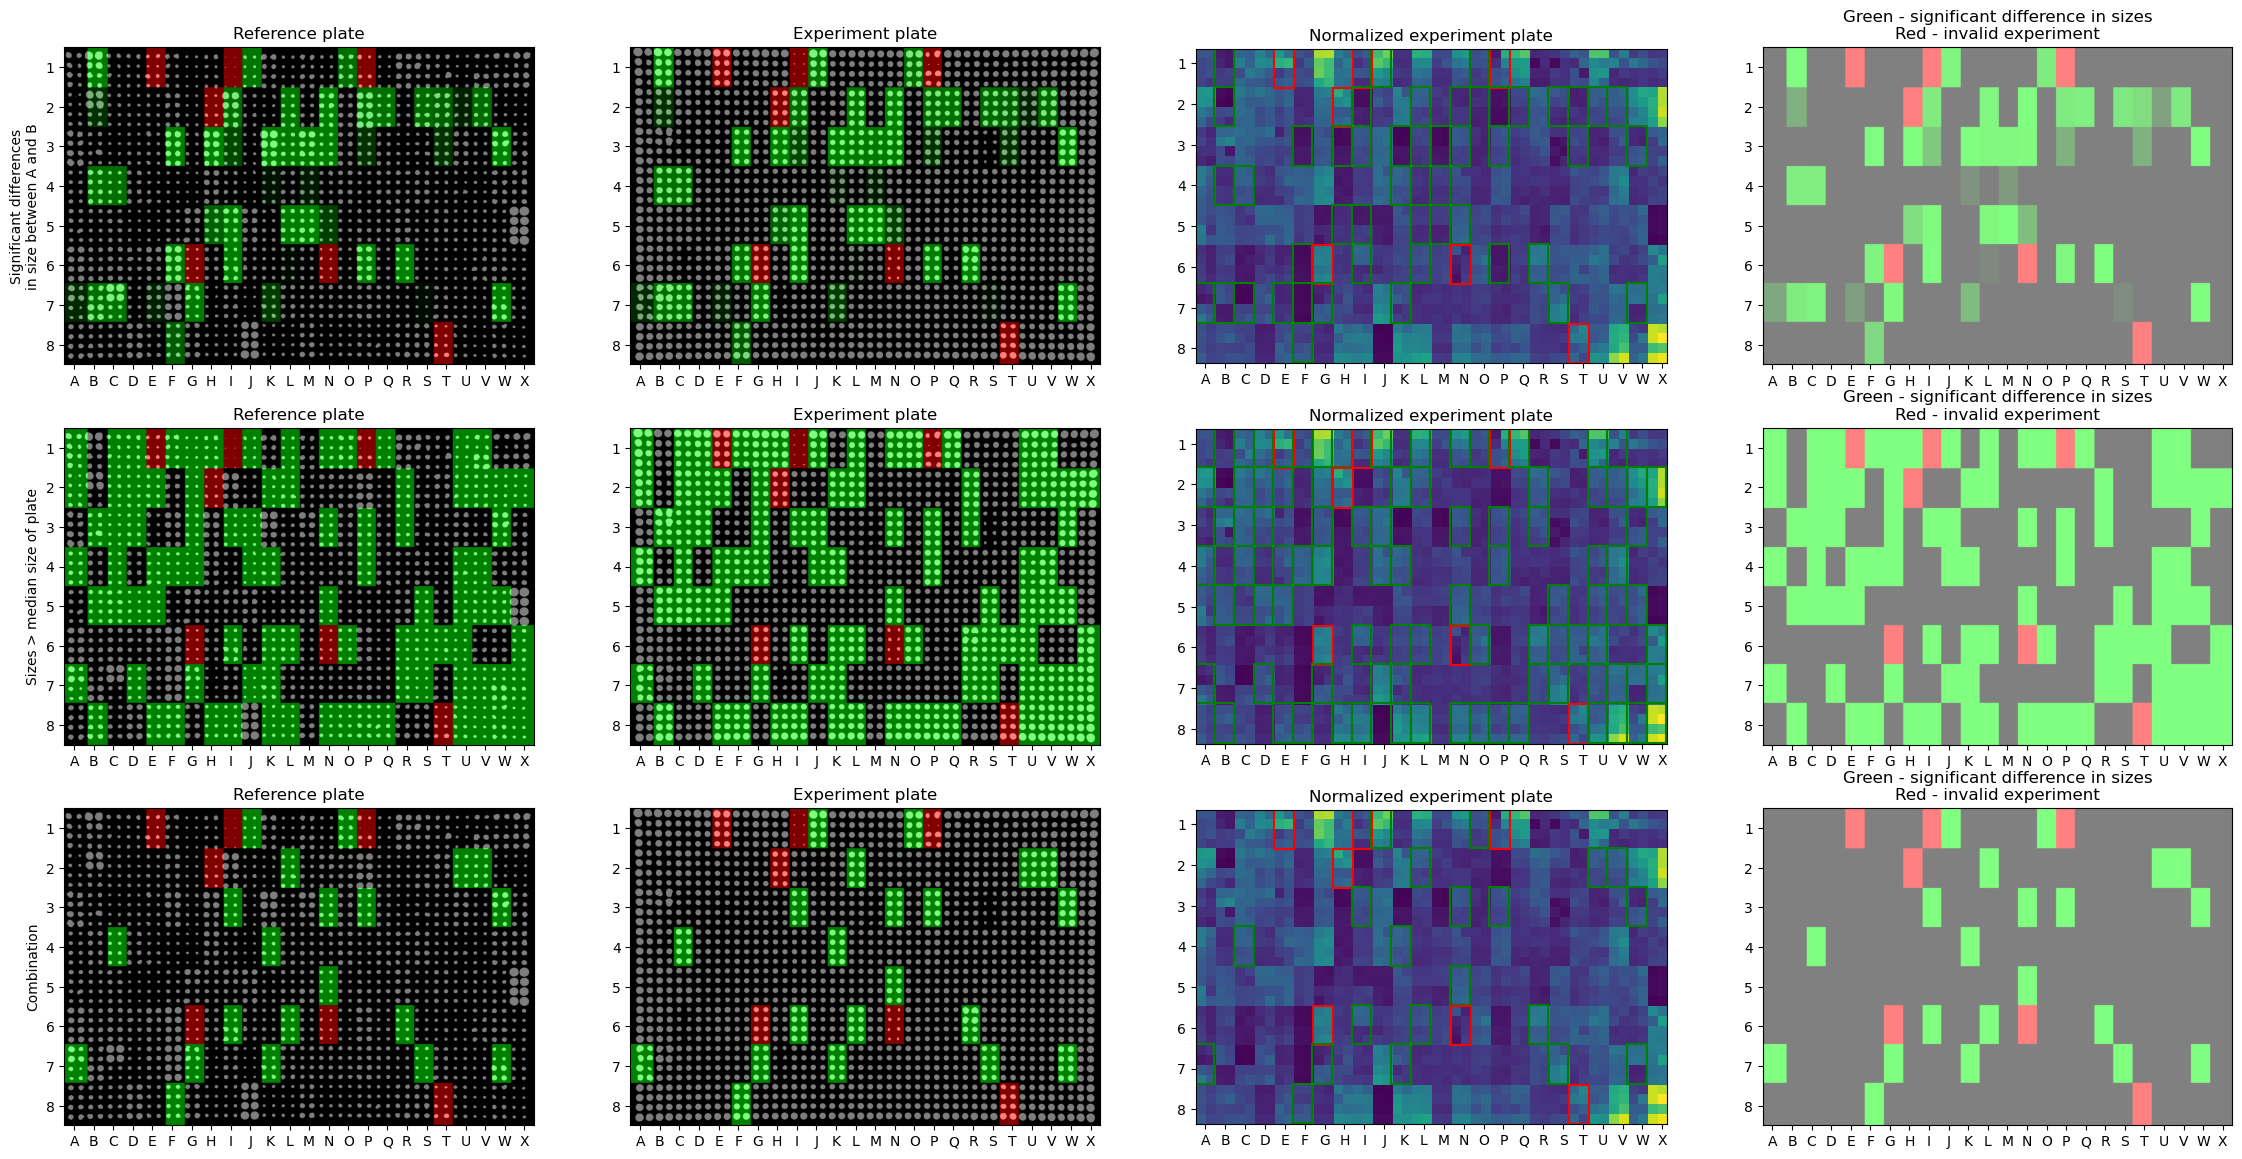

In [63]:
quadruples = evaluate(experiment_plate, reference_plate, sizes_experiment, sizes_reference, x_start, x_end, y_start, y_end, MIN_COLONY_SIZE, P_VALUE_NULLHYPOTHESIS, PERCENTILE, log_dir = save_results_folder+"Result_"+str(Path(path_to_experiment_plate).stem)+".pdf")

## Save Data to Excel Sheet

In [64]:
data = {'position': [quad.position[1]+" "+quad.position[0] for quad in quadruples], 
        'name': [str(quad.name) for quad in quadruples], 
        'p-value': [quad.p_value for quad in quadruples], 
        'max mean size': [quad.max_mean_growth for quad in quadruples],
        'bigger row': [quad.bigger_row for quad in quadruples],
        'bigger than percentile': [quad.bigger_than_median for quad in quadruples],
        'is valid' : [quad.is_valid for quad in quadruples], 
        'sizes A': [str(quad.quadrupelA.sizes) for quad in quadruples], 
        'sizes B': [str(quad.quadrupelB.sizes) for quad in quadruples],
        'ordinal scale': [quad.ordinal_scale for quad in quadruples]}
df = pd.DataFrame(data=data)    

df = df.sort_values(by=['ordinal scale'], ascending=False)
df.to_excel(save_results_folder+"/Result_"+str(Path(path_to_experiment_plate).stem)+".xlsx")
df

,position,name,p-value,max mean size,bigger row,bigger than percentile,is valid,sizes A,sizes B,ordinal scale
0,J 1,,7.112360e-04,5.501822,A,True,True,[5.28008299 5.92225201 5.65217391 5.15277778],[4.27748691 3.72386059 3.53457447 3.27513228],362
1,R 6,,2.856986e-05,3.321930,A,True,True,[3.23943662 3.43243243 3.3893617 3.22648752],[2.40899796 2.50793651 2.60332542 2.56984479],354
2,W 7,,4.461982e-08,2.989586,A,True,True,[2.90989011 2.94444444 3.08838384 3.015625 ],[1.07495591 1.10271159 1.15540541 1.23925234],351
3,I 6,,1.910236e-04,2.651442,A,True,True,[2.77178423 2.65983607 2.57373737 2.60040984],[1.32734531 1.24131082 1.36228814 1.67253045],326
4,S 7,,9.014709e-03,3.545788,B,True,True,[2.5875 2.05421687 2.6849711 3. ],[3.31481481 3.79151943 3.41747573 3.65934066],320
...,...,...,...,...,...,...,...,...,...,...
77,T 7,,3.492377e-01,1.656775,A,False,True,[1.62219101 1.79037267 1.67459138 1.5399449 ],[1.46468401 1.60147059 1.26622662 1.78494624],-1
78,D 6,,1.596430e-01,1.668659,B,False,True,[1.30411255 1.49208443 1.15225933 1.6893039 ],[1.60490463 1.46822309 1.61179698 1.98971193],-1
79,I 5,,2.516684e-04,1.681276,B,False,True,[0.85973597 0.90834846 0.89495366 0.89558665],[1.63885267 1.78818444 1.71911765 1.57894737],-1
80,B 1,,2.316757e-04,1.699209,B,False,True,[0.98104449 0.87141124 1.16129032 0.87297921],[1.58852868 1.80227273 1.74327122 1.66276347],-1
